## 2. Basic Quantum Algorithms
### 2.1. Grover's Algorithm

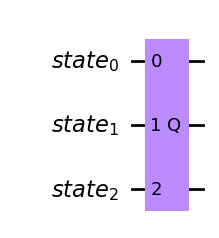

In [135]:
from qiskit import QuantumCircuit,transpile
from qiskit.algorithms import AmplificationProblem

good_state = ['111']
oracle = QuantumCircuit(3)
problem = AmplificationProblem(oracle, is_good_state=good_state)
problem.grover_operator.draw(output='mpl')

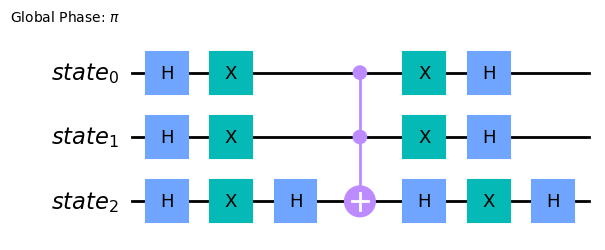

In [36]:
problem.grover_operator.decompose().draw("mpl")

In [46]:
from qiskit import Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover

aer_simulator = Aer.get_backend('aer_simulator')
grover = Grover(quantum_instance=aer_simulator)
result = grover.amplify(problem)
print('Success!' if result.oracle_evaluation else 'Failure!')
print('Top measurement:', result.top_measurement)

Failure!
Top measurement: 101


### 2.2 Quantum InnerProduct

In [141]:
from qiskit_machine_learning.circuit.library import RawFeatureVector
import numpy as np

In [178]:
x_1 = np.array([1,0,1,0])
x_2 = np.array([0,1,0,1])
n_kernel = int(np.ceil(np.log2(len(x_1))))
n_kernel

2

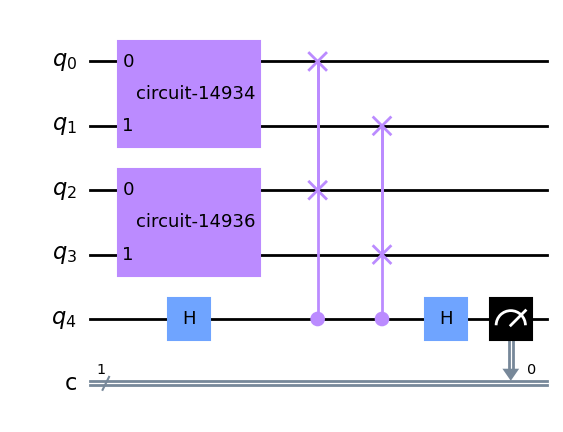

In [179]:
qc = QuantumCircuit(2*n_kernel+1,1)
qc.h(n_kernel*2)
gate_1 = RawFeatureVector(2**n_kernel).assign_parameters(x_1)
gate_2 = RawFeatureVector(2**n_kernel).assign_parameters(x_2)
qc.append(gate_1,range(n_kernel))
qc.append(gate_2,range(n_kernel,(n_kernel*2)))

for i in range(n_kernel):
    qc.cswap(n_kernel*2,i,i+n_kernel)
qc.h(n_kernel*2)
qc.measure(n_kernel*2,0)
qc.draw("mpl")

$(I\otimes I \otimes H)CSWAP(I\otimes I \otimes H)\ket{\psi_1 \psi_2 0} =  \frac{1}{\sqrt{2}}(I\otimes I \otimes H)CSWAP\ket{\psi_1 \psi_2}(\ket{0}+\ket{1}) \\
 \qquad \qquad \qquad \qquad \qquad \qquad \qquad = \frac{1}{\sqrt{2}}(I\otimes I \otimes H)(\ket{\psi_1 \psi_2}\ket{0}+\ket{\psi_2 \psi_1}\ket{1}) \\
 \qquad \qquad \qquad \qquad \qquad \qquad \qquad = \frac{1}{2}\ket{\psi_1 \psi_2}(\ket{0}+\ket{1})+\frac{1}{2}\ket{\psi_2 \psi_1}(\ket{0}-\ket{1}) \\
 \qquad \qquad \qquad \qquad \qquad \qquad \qquad = \frac{1}{2}(\ket{\psi_1 \psi_2}+\ket{\psi_2 \psi_1})\ket{0} + \frac{1}{2}(\ket{\psi_1 \psi_2}-\ket{\psi_2 \psi_1})\ket{1}$

$
Pr(0) = \frac{1}{4} (\bra{\psi_1\psi_2}+\bra{\psi_2\psi_1})(\ket{\psi_1 \psi_2} + \ket{\psi_2 \psi_1}) \\ 
\qquad =\frac{1}{4}(2+2Re^2(\langle \psi_1 \psi_2 \rangle))
$

$Re(\langle \psi_1 \psi_2 \rangle) = \sqrt{2Pr(0)-1}$

In [180]:
shots = 1024
backend = QasmSimulator()
qc_transpile = transpile(qc,backend)
job = backend.run(qc_transpile, shots=shots)
job.result().get_counts()

{'1': 512, '0': 512}

In [181]:
pr_0 = job.result().get_counts()["0"]/shots
np.sqrt(2*pr_0-1)

0.0

In [182]:
x_1@x_2

0

In [186]:
def swap_inner(x_1,x_2,shots = 10000):
    x_1 = np.asarray(x_1)
    x_2 = np.asarray(x_2)
    n_kernel = int(np.ceil(np.log2(len(x_1))))
    qc = QuantumCircuit(2*n_kernel+1,1)
    qc.h(n_kernel*2)
    gate_1 = RawFeatureVector(2**n_kernel).assign_parameters(x_1)
    gate_2 = RawFeatureVector(2**n_kernel).assign_parameters(x_2)
    qc.append(gate_1,range(n_kernel))
    qc.append(gate_2,range(n_kernel,(n_kernel*2)))

    for i in range(n_kernel):
        qc.cswap(n_kernel*2,i,i+n_kernel)
    qc.h(n_kernel*2)
    qc.measure(n_kernel*2,0)
    backend = QasmSimulator()
    qc_transpile = transpile(qc,backend)
    job = backend.run(qc_transpile, shots=shots)
    pr_0 = job.result().get_counts()["0"]/shots
    return np.sqrt(2*pr_0-1)

In [187]:
x_1 = np.asarray([0,0,1,1])
x_1 = x_1/np.linalg.norm(x_1)
x_2 = np.asarray([1,1,0,1])
x_2 = x_2/np.linalg.norm(x_2)
cal_inner(x_1,x_2)

0.39522145690738997

In [188]:
x_1@x_2

0.408248290463863